In [1]:
# Import libraries/packages
import pandas as pd
import googlemaps, polyline
import matplotlib.pyplot as plt
import os
import pickle
from pathlib import Path

In [27]:
# Load original dataset
ROOT = Path.cwd().parent
fuel_data_raw = pd.read_csv(ROOT / 'data/raw/fuel_data_raw.csv')
fuel_data_raw_anon = pd.read_csv(ROOT / 'data/raw/fuel_data_raw_anon.csv')
station_demand = pd.read_csv(ROOT / 'data/processed/station_demand_julia.csv')

In [21]:
# Initialize Google Maps client
API_KEY = ""
CACHE_FILE = "route_cache.pkl" 

use_api = bool(API_KEY)
gmaps = googlemaps.Client(key=API_KEY) if use_api else None

if os.path.exists(CACHE_FILE):
    with open(CACHE_FILE, "rb") as f:
        route_cache = pickle.load(f)
    print(f"Loaded {len(route_cache):,} cached routes")
else:
    route_cache = {}
    print("Starting with an empty route cache")

pairs = (
    fuel_data_raw[["Origin_ID", "Origin_Latitude", "Origin_Longitude",
        "Destination_ID", "Destination_Latitude", "Destination_Longitude"]]
    .drop_duplicates()
)

def fetch_route(row):
    origin = (row.Origin_Latitude, row.Origin_Longitude)
    dest   = (row.Destination_Latitude, row.Destination_Longitude)
    key    = (origin, dest)

    if key in route_cache:
        return route_cache[key]

    # Not in cache → call API if allowed
    if use_api:
        resp  = gmaps.directions(origin, dest, mode="driving", alternatives=False)
        poly  = resp[0]["overview_polyline"]["points"]
        route = polyline.decode(poly)
        route_cache[key] = route
        return route

pairs["geometry"] = pairs.apply(fetch_route, axis=1)

if use_api:
    with open(CACHE_FILE, "wb") as f:
        pickle.dump(route_cache, f)
    print(f"Saved {len(route_cache):,} routes to {CACHE_FILE}")

Loaded 51 cached routes


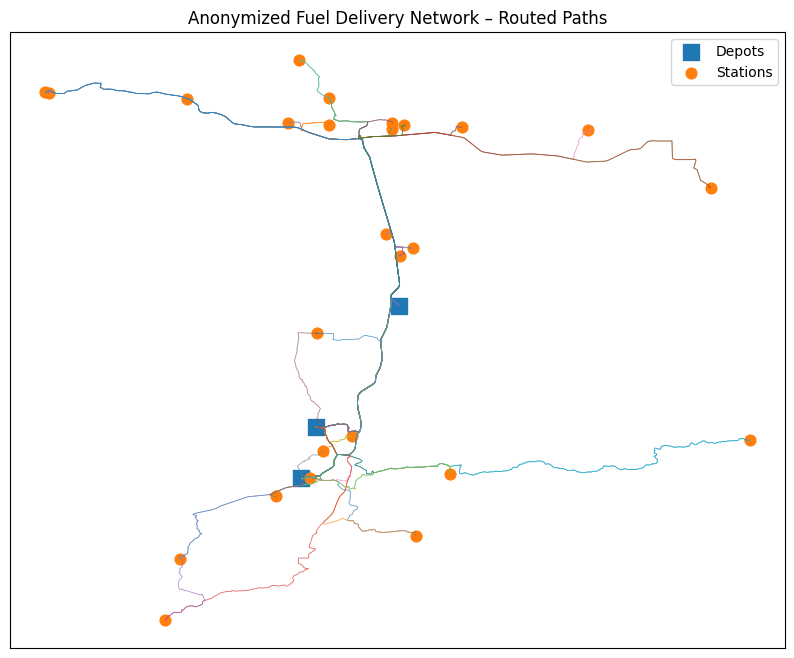

In [22]:
# Find a reference corner and translate everything relative to it
all_lats = [lat for geom in pairs.geometry for lat, _ in geom]
all_lons = [lon for geom in pairs.geometry for _, lon in geom]
lat0, lon0 = min(all_lats), min(all_lons)

def shift_geom(geom):
    return [(lat - lat0, lon - lon0) for lat, lon in geom]

pairs["shifted"] = pairs.geometry.apply(shift_geom)

fig, ax = plt.subplots(figsize=(10, 8))

# Draw every shifted polyline
for route in pairs.shifted:
    xs, ys = zip(*[(lon, lat) for lat, lon in route])
    ax.plot(xs, ys, linewidth=0.6, alpha=0.7)

# Depots
origins = (
    pairs.groupby("Origin_ID")["shifted"]
         .apply(lambda g: g.iloc[0][0]) 
         .apply(pd.Series)
         .rename(columns={0: "Shifted_Oy", 1: "Shifted_Ox"})
         .reset_index()
)
ax.scatter(origins["Shifted_Ox"], origins["Shifted_Oy"], marker="s", s=120, label="Depots")

# Stations
destinations = (
    pairs.groupby("Destination_ID")["shifted"]
         .apply(lambda g: g.iloc[0][-1])
         .apply(pd.Series)
         .rename(columns={0: "Shifted_Dy", 1: "Shifted_Dx"})
         .reset_index()
)
ax.scatter(destinations["Shifted_Dx"], destinations["Shifted_Dy"], marker="o", s=60, label="Stations")

# Remove geographic context
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel(""); ax.set_ylabel("")
ax.set_title("Anonymized Fuel Delivery Network – Routed Paths")
ax.legend()
plt.show()

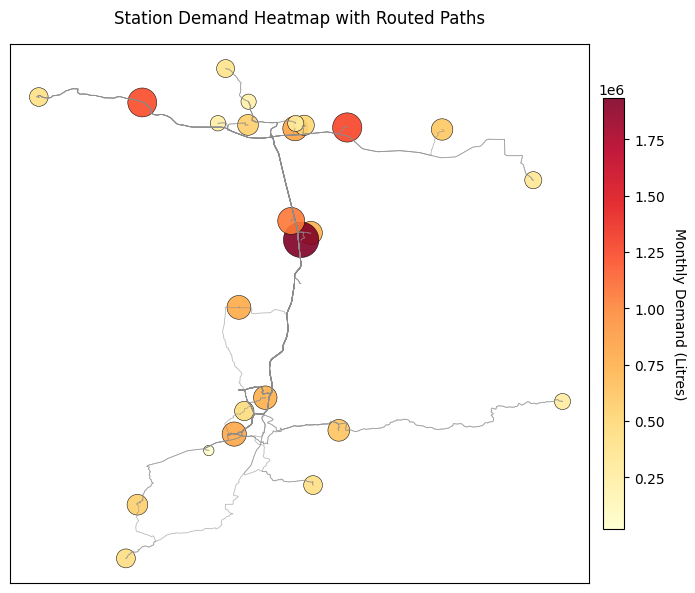

In [33]:
coords = (
    # keep ONLY the columns we need from each table -----------------
    fuel_data_raw_anon[["Delivery_ID", "Destination_ID"]]          # anonymised ID
      .merge(
          fuel_data_raw[[
              "Delivery_ID",
              "Destination_Latitude",
              "Destination_Longitude"
          ]],
          on="Delivery_ID",
          how="left"
      )
      .drop_duplicates(subset=["Destination_ID"])                  # works now
      .set_index("Destination_ID")[["Destination_Latitude", "Destination_Longitude"]]
)

demand = (
    station_demand
      .groupby("Destination_ID", as_index=False)["Monthly_Demand_Liters"]
      .sum()
      .merge(coords, on="Destination_ID", how="left")
      .dropna(subset=["Destination_Latitude"])
)

# 2   Create one common shift so lines and points share the same frame
all_lats = [lat for geom in pairs.geometry for lat, _ in geom] + demand["Destination_Latitude"].tolist()
all_lons = [lon for geom in pairs.geometry for _, lon in geom] + demand["Destination_Longitude"].tolist()
lat0, lon0 = min(all_lats), min(all_lons)

# shift demand coords (you already do this)
demand["x"] = demand["Destination_Longitude"] - lon0
demand["y"] = demand["Destination_Latitude"]  - lat0

# also shift every route polyline (once)
pairs["shifted"] = pairs.geometry.apply(
    lambda geom: [(lat - lat0, lon - lon0) for lat, lon in geom]
)

# --- Plot heat‑style scatter with filled circles ---
plt.figure(figsize=(9, 7))
ax = plt.gca()

# 3a. Routed polylines (grey background paths)
for route in pairs["shifted"]:
    xs, ys = zip(*[(lon, lat) for lat, lon in route])
    ax.plot(xs, ys, linewidth=0.6, alpha=0.6, color="#8c8c8c")

# 3b. Demand circles
scatter = ax.scatter(
    demand["x"], demand["y"],
    c=demand["Monthly_Demand_Liters"],
    cmap="YlOrRd",
    s=demand["Monthly_Demand_Liters"] / demand["Monthly_Demand_Liters"].max() * 600 + 50,
    marker="o", edgecolors="k", linewidths=0.4, alpha=0.9
)

# 3c. Presentation tweaks
ax.set_facecolor("white")
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel(""); ax.set_ylabel("")
ax.set_title("Station Demand Heatmap with Routed Paths", pad=15)

cbar = plt.colorbar(scatter, shrink=0.8, pad=0.02)
cbar.set_label("Monthly Demand (Litres)", rotation=270, labelpad=15)

plt.show()